# Low-Rank Approximation Fine-Tuning

This notebook demonstrates encrypted fine-tuning of a small MLP model with LoRA. A model trained on an initial dataset is adapted to a second dataset using LoRA fine-tuning.

The fine-tuning dataset and the LoRA weights that are trained are protected using encryption. Thus, the training can be outsourced to a remote server without leaking any sensitive data.

The hybrid model approach is applied to fine-tuning: only the linear layers of the original model are outsourced to the server. The forward and backward passes on these original weights are performed with encrypted activations and gradients. The LoRA weights are kept by the client, and the client performs the forward and backward passes on the LoRA weights.

In [1]:
import shutil
import time
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
from peft import LoraConfig, get_peft_model
from sklearn.datasets import make_circles, make_moons
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

from concrete.ml.torch.hybrid_model import HybridFHEModel
from concrete.ml.torch.lora import LoraTraining, get_remote_names

# Set random seed for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

## Data preparation

Two datasets are generated: one for the original training, and a second one on which LORA fine-tuning is performed.

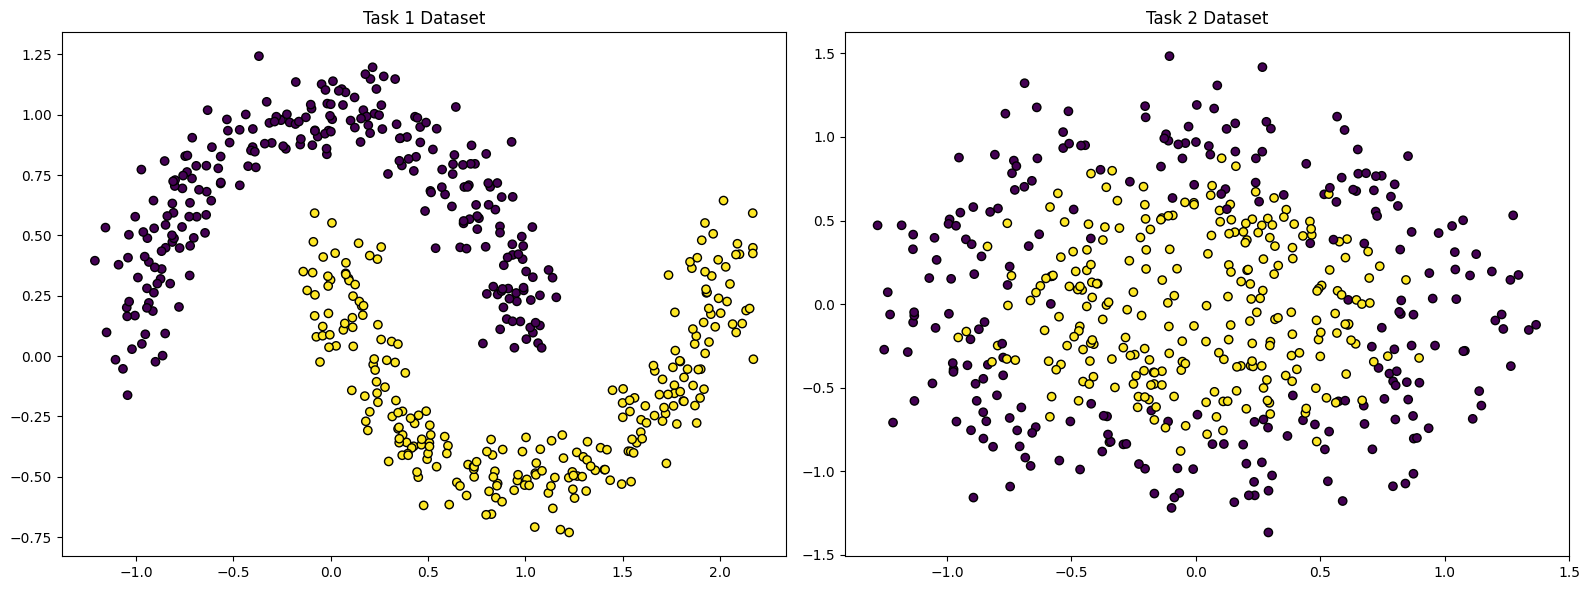

In [2]:
# Task 1: Two interleaving half circles (make_moons)
X_task1, y_task1 = make_moons(n_samples=500, noise=0.1)
# Task 2: Two concentric circles
X_task2, y_task2 = make_circles(n_samples=500, noise=0.2, factor=0.5)


def plot_datasets_and_boundaries(X_task1, y_task1, X_task2, y_task2, model=None, titles=None):
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    if titles is None:
        titles = ["Task 1 Dataset", "Task 2 Dataset"]

    for ax, X, y, title in zip([ax1, ax2], [X_task1, X_task2], [y_task1, y_task2], titles):
        ax.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis", edgecolor="k")
        ax.set_title(title)

        if model is not None:
            x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
            y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
            h = 0.1  # step size in the mesh
            xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
            grid = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])

            with torch.no_grad():
                Z = model(grid)
                probabilities = torch.softmax(Z, dim=1)
                Z = probabilities[:, 1].numpy().reshape(xx.shape)

            ax.contourf(xx, yy, Z, cmap="viridis", alpha=0.3)

    plt.tight_layout()
    plt.show()


# Plot datasets
plot_datasets_and_boundaries(X_task1, y_task1, X_task2, y_task2)

## Create the original MLP and test it

Training on Task 1 without LoRA:


Epoch [20/20], Loss: 0.0036


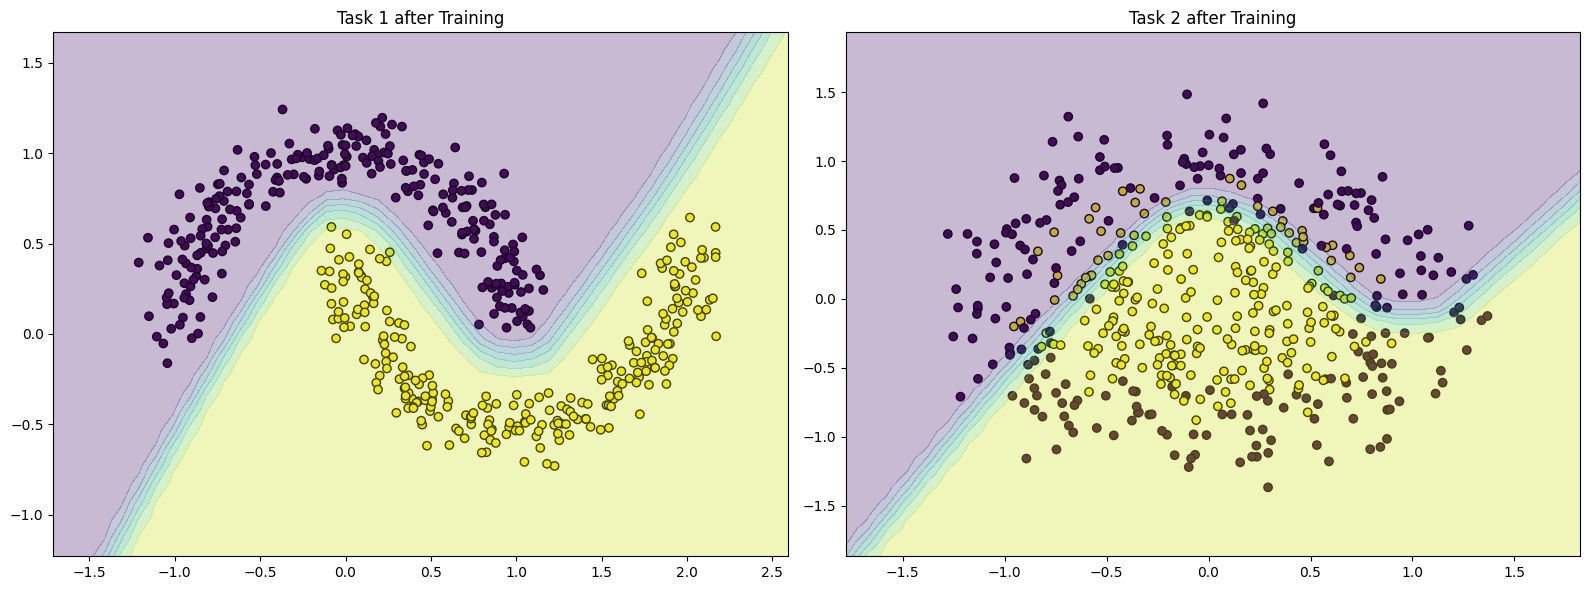

In [3]:
# Convert datasets to PyTorch tensors
X_task1 = torch.FloatTensor(X_task1)
y_task1 = torch.LongTensor(y_task1)
X_task2 = torch.FloatTensor(X_task2)
y_task2 = torch.LongTensor(y_task2)

# Create DataLoaders
batch_size = 32
train_loader_task1 = DataLoader(
    TensorDataset(X_task1, y_task1), batch_size=batch_size, shuffle=True
)
train_loader_task2 = DataLoader(
    TensorDataset(X_task2, y_task2), batch_size=batch_size, shuffle=True
)

# Define an MLP model without LoRA layers


class SimpleMLP(nn.Module):
    """Simple MLP model without LoRA layers."""

    def __init__(self, input_size=2, hidden_size=128, num_classes=2):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        """Forward pass of the MLP."""
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out


# Instantiate the model
model = SimpleMLP()

# Training loop for Task 1


def train_model(model, train_loader, num_epochs=100):
    """Train the model.

    Args:
        model (nn.Module): The model to train.
        train_loader (DataLoader): DataLoader for training data.
        num_epochs (int): Number of epochs to train.
    """
    device = torch.device("cpu")
    model.to(device)
    model.train()

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    for epoch in range(num_epochs):
        total_loss = 0
        for x_batch, y_batch in train_loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        # Print loss every 20 epochs
        if (epoch + 1) % 20 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}")


# Train the model on Task 1
print("Training on Task 1 without LoRA:")
train_model(model, train_loader_task1, num_epochs=20)

# Plot datasets with decision boundaries
plot_datasets_and_boundaries(
    X_task1.numpy(),
    y_task1.numpy(),
    X_task2.numpy(),
    y_task2.numpy(),
    model=model,
    titles=["Task 1 after Training", "Task 2 after Training"],
)

## Apply LoRA to the model using peft

In [4]:
# Apply LoRA to the model using peft
lora_config = LoraConfig(
    r=1, lora_alpha=1, lora_dropout=0.01, target_modules=["fc1", "fc2"], bias="none"
)

peft_model = get_peft_model(model, lora_config)

## Setup FHE fine-tuning with LoraTraining and HybridFHEModel

In [5]:
# Set up LoRA training
lora_training = LoraTraining(peft_model)

# Set up optimizer and scheduler
optimizer = optim.Adam(filter(lambda p: p.requires_grad, peft_model.parameters()), lr=0.01)

# Update training parameters, including loss function
lora_training.update_training_parameters(
    optimizer=optimizer,
    loss_fn=nn.CrossEntropyLoss(),
    training_args={"gradient_accumulation_steps": 1},
)

# Create the HybridFHEModel
remote_names = get_remote_names(lora_training)
hybrid_model = HybridFHEModel(lora_training, module_names=remote_names)

# Prepare input data for calibration
batch_size_per_task = batch_size // 2
inputset = (
    torch.cat([X_task1[:batch_size_per_task], X_task2[:batch_size_per_task]]),
    torch.cat([y_task1[:batch_size_per_task], y_task2[:batch_size_per_task]]),
)

# Calibrate and compile the model
lora_training.toggle_calibrate(enable=True)
hybrid_model.compile_model(inputset, n_bits=8)
lora_training.toggle_calibrate(enable=False)

Compilation device override, was 'cpu' -> change to 'cuda'
Compilation device override, was 'cpu' -> change to 'cuda'
Compilation device override, was 'cpu' -> change to 'cuda'


In [6]:
# Fine-tune the model on Task 2 using LoRA


def train_hybrid_model(hybrid_model, train_loader, num_epochs=50, fhe="disable"):
    """Train the model using the hybrid FHE model with gradient accumulation.

    Args:
        hybrid_model (HybridFHEModel): The compiled hybrid model.
        train_loader (DataLoader): DataLoader for training data.
        num_epochs (int): Number of epochs to train.
        fhe (str): FHE mode ('disable', 'simulate', or 'execute').
    """
    device = torch.device("cpu")
    lora_training.to(device)
    peft_model.train()
    lora_training.toggle_run_optimizer(enable=True)

    # Create the main epoch progress bar
    epoch_pbar = tqdm(range(1, num_epochs + 1), desc="Training", unit="epoch")

    for epoch in epoch_pbar:
        total_loss = 0
        start_time = time.time()

        for x_batch, y_batch in train_loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            loss, _ = hybrid_model((x_batch, y_batch), fhe=fhe)
            total_loss += loss.item()

        # Calculate average loss and epoch time
        avg_loss = total_loss / len(train_loader)
        epoch_time = time.time() - start_time

        # Update epoch progress bar
        epoch_pbar.set_postfix(
            {
                "Epoch": epoch,
                "Avg Loss": f"{avg_loss:.4f}",
                "Time": f"{epoch_time:.2f}s",
                "FHE Mode": fhe,
            }
        )

    print(f"Training completed. Final Avg Loss: {avg_loss:.4f}, FHE Mode: {fhe}")


print("Fine-tuning on Task 2 with LoRA:")
train_hybrid_model(hybrid_model, train_loader_task2, num_epochs=10, fhe="execute")

Fine-tuning on Task 2 with LoRA:


Training:   0%|          | 0/10 [00:00<?, ?epoch/s]

Training:   0%|          | 0/10 [00:27<?, ?epoch/s, Epoch=1, Avg Loss=2.3775, Time=27.97s, FHE Mode=execute]

Training:  10%|█         | 1/10 [00:27<04:11, 27.97s/epoch, Epoch=1, Avg Loss=2.3775, Time=27.97s, FHE Mode=execute]

Training:  10%|█         | 1/10 [00:56<04:11, 27.97s/epoch, Epoch=2, Avg Loss=1.6292, Time=28.74s, FHE Mode=execute]

Training:  20%|██        | 2/10 [00:56<03:47, 28.42s/epoch, Epoch=2, Avg Loss=1.6292, Time=28.74s, FHE Mode=execute]

Training:  20%|██        | 2/10 [01:25<03:47, 28.42s/epoch, Epoch=3, Avg Loss=0.8214, Time=28.85s, FHE Mode=execute]

Training:  30%|███       | 3/10 [01:25<03:20, 28.62s/epoch, Epoch=3, Avg Loss=0.8214, Time=28.85s, FHE Mode=execute]

Training:  30%|███       | 3/10 [01:54<03:20, 28.62s/epoch, Epoch=4, Avg Loss=0.5415, Time=29.11s, FHE Mode=execute]

Training:  40%|████      | 4/10 [01:54<02:52, 28.81s/epoch, Epoch=4, Avg Loss=0.5415, Time=29.11s, FHE Mode=execute]

Training:  40%|████      | 4/10 [02:23<02:52, 28.81s/epoch, Epoch=5, Avg Loss=0.3884, Time=29.11s, FHE Mode=execute]

Training:  50%|█████     | 5/10 [02:23<02:24, 28.92s/epoch, Epoch=5, Avg Loss=0.3884, Time=29.11s, FHE Mode=execute]

Training:  50%|█████     | 5/10 [02:52<02:24, 28.92s/epoch, Epoch=6, Avg Loss=0.3246, Time=29.08s, FHE Mode=execute]

Training:  60%|██████    | 6/10 [02:52<01:55, 28.98s/epoch, Epoch=6, Avg Loss=0.3246, Time=29.08s, FHE Mode=execute]

Training:  60%|██████    | 6/10 [03:21<01:55, 28.98s/epoch, Epoch=7, Avg Loss=0.3145, Time=28.88s, FHE Mode=execute]

Training:  70%|███████   | 7/10 [03:21<01:26, 28.94s/epoch, Epoch=7, Avg Loss=0.3145, Time=28.88s, FHE Mode=execute]

Training:  70%|███████   | 7/10 [03:50<01:26, 28.94s/epoch, Epoch=8, Avg Loss=0.2943, Time=29.10s, FHE Mode=execute]

Training:  80%|████████  | 8/10 [03:50<00:57, 28.99s/epoch, Epoch=8, Avg Loss=0.2943, Time=29.10s, FHE Mode=execute]

Training:  80%|████████  | 8/10 [04:18<00:57, 28.99s/epoch, Epoch=9, Avg Loss=0.2913, Time=27.92s, FHE Mode=execute]

Training:  90%|█████████ | 9/10 [04:18<00:28, 28.66s/epoch, Epoch=9, Avg Loss=0.2913, Time=27.92s, FHE Mode=execute]

Training:  90%|█████████ | 9/10 [04:47<00:28, 28.66s/epoch, Epoch=10, Avg Loss=0.2979, Time=28.82s, FHE Mode=execute]

Training: 100%|██████████| 10/10 [04:47<00:00, 28.71s/epoch, Epoch=10, Avg Loss=0.2979, Time=28.82s, FHE Mode=execute]

Training: 100%|██████████| 10/10 [04:47<00:00, 28.76s/epoch, Epoch=10, Avg Loss=0.2979, Time=28.82s, FHE Mode=execute]

Training completed. Final Avg Loss: 0.2979, FHE Mode: execute


## Visualize fine-tuned model

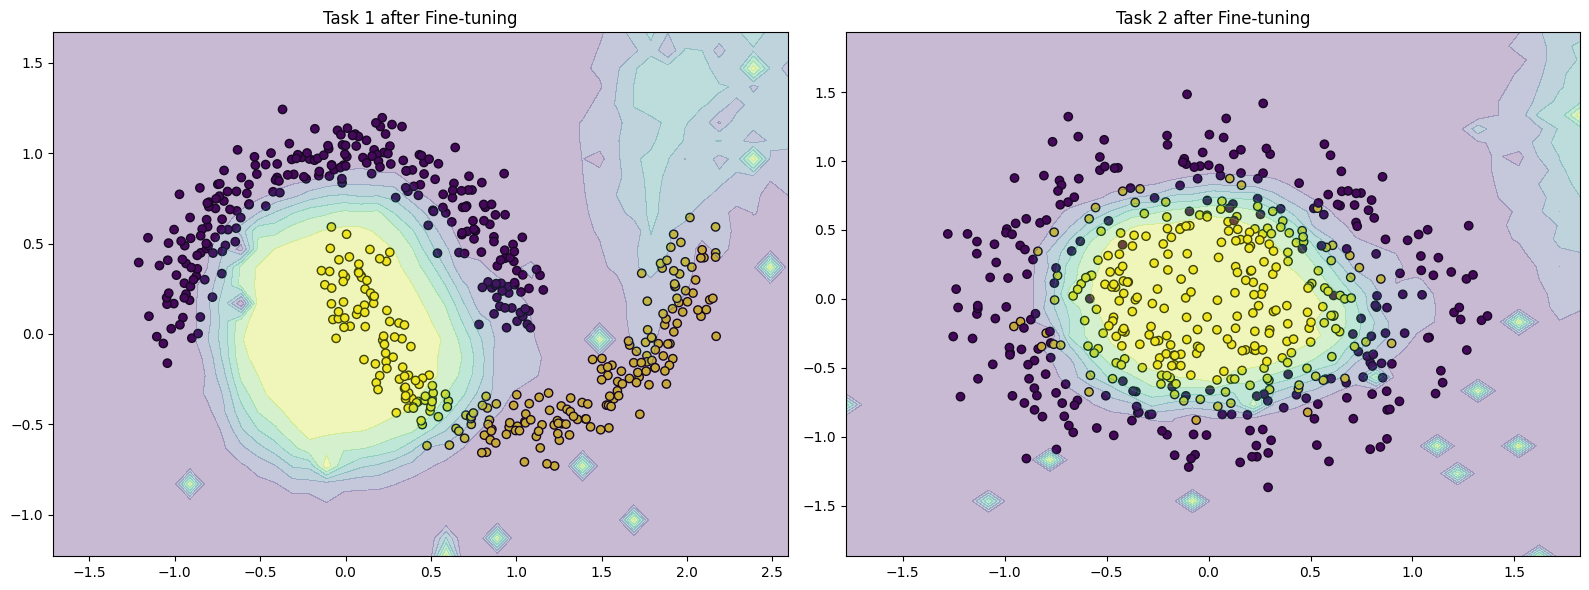

In [7]:
# Enable LoRA adapters (already enabled by default)
peft_model.enable_adapter_layers()

# Plot datasets with decision boundaries after fine-tuning
plot_datasets_and_boundaries(
    X_task1.numpy(),
    y_task1.numpy(),
    X_task2.numpy(),
    y_task2.numpy(),
    model=peft_model,
    titles=["Task 1 after Fine-tuning", "Task 2 after Fine-tuning"],
)

## Disable LoRA adapters to see the original model

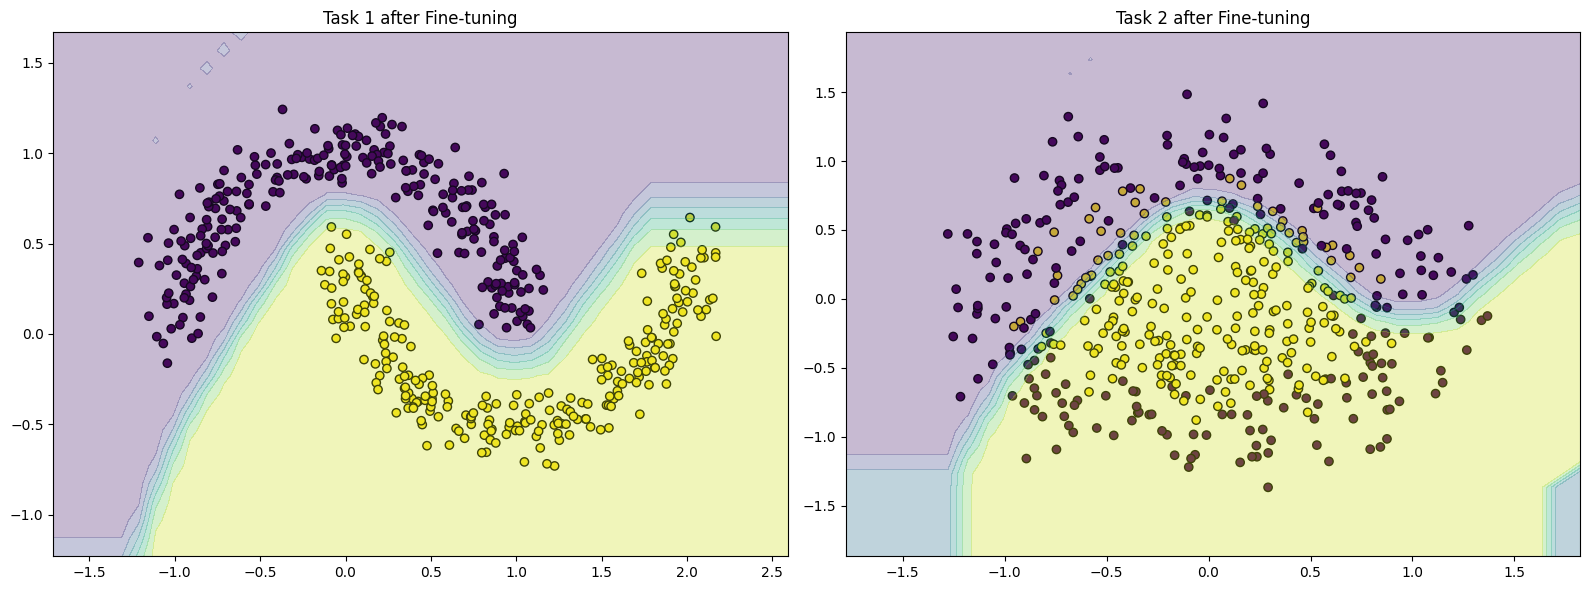

In [8]:
# Disable LoRA adapters
peft_model.disable_adapter_layers()

# Plot datasets with decision boundaries after fine-tuning
plot_datasets_and_boundaries(
    X_task1.numpy(),
    y_task1.numpy(),
    X_task2.numpy(),
    y_task2.numpy(),
    model=peft_model,
    titles=["Task 1 after Fine-tuning", "Task 2 after Fine-tuning"],
)

## Print statistics and save the model

In [9]:
# Enable LoRA adapters (already enabled by default)
peft_model.enable_adapter_layers()

# Print trainable (lora) parameters
peft_model.print_trainable_parameters()

# Save the model and remove all layers that will be done on the server
path = Path("lora_mlp")

if path.is_dir() and any(path.iterdir()):
    shutil.rmtree(path)

hybrid_model.save_and_clear_private_info(path)

# At this point, the hybrid_model only contains the trainable parameters of the LoRA layers.
peft_model.print_trainable_parameters()

trainable params: 260 || all params: 902 || trainable%: 28.8248
trainable params: 260 || all params: 260 || trainable%: 100.0000


## Conclusion

This notebook demonstrates how Low-Rank Adaptation (LoRA) facilitates parameter-efficient fine-tuning of models on private data. By leveraging FHE, the training process ensures that sensitive data and private model updates remains secure.
 
**Key Takeaways:**
 
- **Efficiency with LoRA:** While this example utilizes an MLP model with a relatively high proportion of LoRA weights due to its simplicity, the approach scales effectively to larger models like large language models (LLMs). In such cases, LoRA typically accounts for **less than one percent** of the total model parameters, ensuring minimal memory and computational overhead on the client side.
- **Scalability and Practicality:** The hybrid model approach demonstrated here is particularly beneficial for scenarios where client devices have limited resources. Memory heavy computations are offloaded to a secure server and the client handles only the lightweight LoRA adjustments locally.